# Formative 3

In [1]:
import re
from html import unescape

import pandas as pd
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from collections import defaultdict, Counter
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None

### Part I: Data Preparation and Helper Functions

In [3]:
# Define function to clean and split text
def clean(text):
    text = unescape(text)
    return [re.sub('[^a-z0-9]', '', w.lower()) for w in text.strip().split()]

In [4]:
# Load dataframe
df = pd.read_csv('reddit_mbti.csv')

# Remove columns not needed for formative
#df = df[['comment', 'type']]

# Remove empty comments
df = df[df.comment.apply(lambda x: len(clean(x))) > 0]

In [5]:
df['score']

0        1.0
1        5.0
2        1.0
3        2.0
4        1.0
        ... 
76656    9.0
76657    1.0
76658   -4.0
76659    0.0
76660    0.0
Name: score, Length: 76659, dtype: float64

In [6]:
df.columns

Index(['Unnamed: 0', 'name', 'author', 'author_flair_text', 'downs',
       'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score',
       'controversiality', 'gilded', 'id', 'subreddit', 'ups', 'type',
       'word_count', 'word_count_quoteless', 'quote_to_text_ratio',
       'is_mbti_related', 'comment', 'lang'],
      dtype='object')

In [7]:
df.columns

Index(['Unnamed: 0', 'name', 'author', 'author_flair_text', 'downs',
       'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score',
       'controversiality', 'gilded', 'id', 'subreddit', 'ups', 'type',
       'word_count', 'word_count_quoteless', 'quote_to_text_ratio',
       'is_mbti_related', 'comment', 'lang'],
      dtype='object')

In [8]:
from datetime import datetime

In [9]:
datetime.utcfromtimestamp(df['created_utc'].min())

datetime.datetime(2015, 1, 1, 0, 39, 53)

In [10]:
datetime.utcfromtimestamp(df['created_utc'].max())

datetime.datetime(2017, 10, 31, 23, 53, 46)

In [11]:
df['date'] = df['created_utc'].map(lambda day: datetime.strftime(datetime.utcfromtimestamp(day), '%Y-%m'))

<AxesSubplot:>

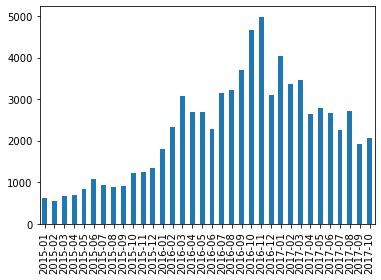

In [12]:
df['date'].value_counts().sort_index().plot(kind='bar')

In [13]:
df.head()

,Unnamed: 0,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,...,subreddit,ups,type,word_count,word_count_quoteless,quote_to_text_ratio,is_mbti_related,comment,lang,date
0,0,NaN,procrastablasta,NaN,0.0,1.479440e+09,t5_2cneq,t3_5dhlfi,t1_da568p7,1.0,...,politics,0.0,enfp,72,72,0.00000,False,you really want to go down this path? Would y...,en,2016-11
1,1,NaN,SWaspMale,NaN,0.0,1.451479e+09,t5_2cneq,t3_3ys15l,t3_3ys15l,5.0,...,politics,5.0,intp,25,25,0.00000,False,I think insurance companies do that. Once you...,en,2015-12
2,2,NaN,SWaspMale,NaN,0.0,1.454790e+09,t5_2cneq,t3_44g0e0,t3_44g0e0,1.0,...,politics,1.0,intp,29,29,0.00000,False,"I see it as 22,500 people working for about an...",en,2016-02
3,3,NaN,SWaspMale,NaN,0.0,1.508847e+09,t5_2cneq,t3_78eyz6,t1_dot9vvz,2.0,...,politics,0.0,intp,21,21,0.00000,False,Our President stands ready to ride his golf ca...,en,2017-10
4,4,NaN,SWaspMale,NaN,0.0,1.492797e+09,t5_2cneq,t3_66o9bu,t1_dgk8idx,1.0,...,politics,0.0,intp,54,47,0.12963,False,"Some write that he was trying to say ""big leag...",en,2017-04


In [14]:
df.author.nunique()

1925

In [15]:
import matplotlib.pyplot as plt

In [16]:
sizes = np.array(df.author.value_counts().values)

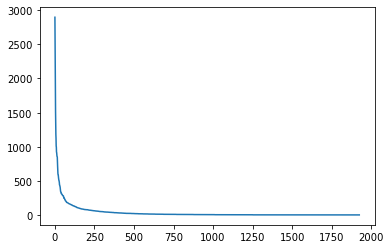

In [17]:
plt.plot(np.array(df.author.value_counts().values))

Text(0, 0.5, 'Log_{e} of the number of comments')

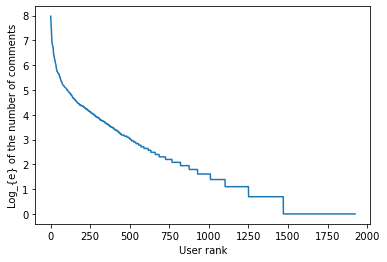

In [18]:
plt.plot(np.log(sizes))
plt.xlabel("User rank")
plt.ylabel("Log_{e} of the number of comments")

In [19]:
df.subreddit_id.nunique()

1

In [20]:
df.parent_id.nunique()

74794

In [21]:
df.link_id.nunique()

23845

In [22]:
df

,Unnamed: 0,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,...,subreddit,ups,type,word_count,word_count_quoteless,quote_to_text_ratio,is_mbti_related,comment,lang,date
0,0,NaN,procrastablasta,NaN,0.0,1.479440e+09,t5_2cneq,t3_5dhlfi,t1_da568p7,1.0,...,politics,0.0,enfp,72,72,0.000000,False,you really want to go down this path? Would y...,en,2016-11
1,1,NaN,SWaspMale,NaN,0.0,1.451479e+09,t5_2cneq,t3_3ys15l,t3_3ys15l,5.0,...,politics,5.0,intp,25,25,0.000000,False,I think insurance companies do that. Once you...,en,2015-12
2,2,NaN,SWaspMale,NaN,0.0,1.454790e+09,t5_2cneq,t3_44g0e0,t3_44g0e0,1.0,...,politics,1.0,intp,29,29,0.000000,False,"I see it as 22,500 people working for about an...",en,2016-02
3,3,NaN,SWaspMale,NaN,0.0,1.508847e+09,t5_2cneq,t3_78eyz6,t1_dot9vvz,2.0,...,politics,0.0,intp,21,21,0.000000,False,Our President stands ready to ride his golf ca...,en,2017-10
4,4,NaN,SWaspMale,NaN,0.0,1.492797e+09,t5_2cneq,t3_66o9bu,t1_dgk8idx,1.0,...,politics,0.0,intp,54,47,0.129630,False,"Some write that he was trying to say ""big leag...",en,2017-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76656,107537,NaN,TheGreasyPole,Foreign,0.0,1.507918e+09,t5_2cneq,t3_764ihr,t1_dobkwtg,9.0,...,politics,0.0,esfj,65,51,0.215385,False,John Kerry was a coward who didn't deserve his...,en,2017-10
76657,107538,NaN,TheGreasyPole,Foreign,0.0,1.508098e+09,t5_2cneq,t3_76i8oa,t1_doedg60,1.0,...,politics,0.0,esfj,65,39,0.400000,False,Kevin Drum has already run the numbers and don...,en,2017-10
76658,107539,NaN,chasingstatues,NaN,0.0,1.508437e+09,t5_2cneq,t3_77ee4k,t1_doldxcj,-4.0,...,politics,0.0,esfj,95,94,0.010526,False,"I mean, can we not acknowledge that Donald Tru...",en,2017-10
76659,107540,NaN,chasingstatues,NaN,0.0,1.508468e+09,t5_2cneq,t3_77ee4k,t1_dom5vsf,0.0,...,politics,0.0,esfj,26,16,0.384615,False,Well the comment I was responding to said this...,en,2017-10


In [23]:
datetime.strftime(datetime.utcfromtimestamp(df['created_utc'].iloc[0]), '%Y-%m')

'2016-11'

In [24]:
df['comment'].iloc[20]

"Yes. Saying what's on your mind might not be polite, but you can't tell me you've never thought of punching somebody in the face. A mean teacher, your dad, some asshole at the supermarket, a bitch ex-girlfriend. Doesn't mean you did it, or would even do it. But boy would you like to be able to.Transcending these feelings is what makes us a better species than others, let's not forget that. Denying you have these feelings is lying to yourself and others."

In [25]:
df['is_mbti_related'].mean()

0.0

In [26]:
df.columns

Index(['Unnamed: 0', 'name', 'author', 'author_flair_text', 'downs',
       'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score',
       'controversiality', 'gilded', 'id', 'subreddit', 'ups', 'type',
       'word_count', 'word_count_quoteless', 'quote_to_text_ratio',
       'is_mbti_related', 'comment', 'lang', 'date'],
      dtype='object')

In [27]:
# Define dictionary for particle look-up
p2id = {'over': 0, 'back': 1, 'around': 2, 'out': 3}

# Define dictionary for reverse particle look-up
id2p = {v: k for k, v in p2id.items()}


In [28]:
# Define dictionary for particle look-up
p2id = {'over': 0, 'back': 1, 'around': 2, 'out': 3}

# Define dictionary for reverse particle look-up
id2p = {v: k for k, v in p2id.items()}

# Initialize lists for storing contexts around particles
sent_1 = list()
sent_2 = list()

# Initialize list for storing labels
labels = list()

# Loop over comments
for c in df.comment:
    
    # Loop over individual sentences
    for s in sent_tokenize(c):
        
        # Clean and split sentence
        split = clean(s)
        
        if len(split) < 10:
            continue
        
        # Add sentence to list if only one particle in sentence
        if len([w for w in split if w in p2id]) == 1:
            
            # Identify particle
            p = [w for w in split if w in p2id][0]

            # Store contexts and label
            sent_1.append(split[:split.index(p)])
            sent_2.append(split[split.index(p) + 1:])
            labels.append(p)

In [104]:
sent_1[2]

['this',
 'subreddit',
 'views',
 'things',
 'too',
 'black',
 'and',
 'whitetheres',
 'more',
 'races']

In [29]:
# Create dataframe with contexts and labels and perform stratified sampling
p_df = pd.DataFrame({'sent_1': sent_1, 'sent_2': sent_2, 'label': labels})[['sent_1', 'sent_2', 'label']]
p_df = p_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=1500, random_state=0)).reset_index(drop=True)

In [30]:
# Split dataframe into training, evaluation, and test data
train, dev_test = train_test_split(p_df, test_size=0.2, stratify=p_df['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

### Part I: Additional changes

In [31]:
train.head()

,sent_1,sent_2,label
1118,"[sandy, had]","[100b, in, funding, and, it, affected, way, mo...",around
852,"[so, once, shes, there, theres, no, reason, to...","[even, if, you, buy, into, the, fallacy, that,...",around
1431,"[as, a, result, they, gained, extraterritorial...","[the, world]",around
4981,"[theyre, the, ones, paying, all, these, politi...","[so, they, can, price, gouge, necessities, for...",over
3221,"[payment, for, class, a, drugs, , 1mhowever, w...",[],out


In [32]:
# Create a dictionary for word look up
word_counter = Counter([w for s in train.sent_1 for w in s] + [w for s in train.sent_2 for w in s])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

In [109]:
len(w2id)

12853

In [33]:
id2w = {i:w for w, i in w2id.items()}

In [34]:
def encode(sent, w2id):
    return [w2id[w] if w in w2id else 1 for w in sent]

In [111]:
encode(sent_1[0], w2id)

[93, 165, 2844, 1227, 3, 2772, 49, 1730, 4721]

In [112]:
sent_1[0]

['our', 'president', 'stands', 'ready', 'to', 'ride', 'his', 'golf', 'cart']

In [35]:
sent = train.sent_1.iloc[1]

In [36]:
def pad(sent):
    if len(sent) > 5:
        sent = sent[-5:]
    elif len(sent) < 5:
        sent = [0] * (5 - len(sent)) + sent
    return sent

In [37]:
pad(train.sent_2.iloc[2])

[0, 0, 0, 'the', 'world']

In [38]:
train.sent_2.iloc[2]

['the', 'world']

In [39]:
# Encode sentences 

for data in [train, dev, test]:
    
    # Encode and pad left contexts
    data['enc_1'] = data.sent_1.apply(lambda x: pad(encode(x, w2id)))
    
    # Encode and pad right contexts
    data['enc_2'] = data.sent_2.apply(lambda x: pad(encode(x, w2id)[::-1]))

In [40]:
w2id['the']

2

In [41]:
train.loc[1431]

sent_1    [as, a, result, they, gained, extraterritorial...
sent_2                                         [the, world]
label                                                around
enc_1                             [745, 371, 3920, 8, 2504]
enc_2                                     [0, 0, 0, 131, 2]
Name: 1431, dtype: object

In [42]:
def train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device):
    
    # Define training objective
    criterion = nn.CrossEntropyLoss()
    
    # Define optimizer
    optimizer = optim.Adam(classifier.parameters(), lr = 0.01)
    
    # Move model and data to CUDA
    classifier = classifier.to(device)
    [train_x, train_y, dev_x, dev_y, test_x, test_y] = [data.to(device) for data in [train_x, train_y, dev_x, dev_y, test_x, test_y]]
    
    for epoch in range(1,21):
        
        # Perform forward pass
        classifier.train()  # <-- how does this work?? What data is he training on?
        optimizer.zero_grad()
        output = classifier(train_x)
        loss = criterion(output, train_y)
        
        # Backprop
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Evaluate model every fifth epoch
        if epoch % 5 == 0:
            
            classifier.eval() # Set classifier to evaluation model
            
            with torch.no_grad():
                
                # Perform forward pass
                output = classifier(dev_x)
                
                # Make prediction
                max_output = output.argmax(dim=1, keepdim = True)
                
                # Compute accuracy
                acc = max_output.squeeze(1).eq(dev_y).sum() / torch.FloatTensor([dev_y.shape[0]])
                
                print("Accuracy on the dev data after {:02d} epochs: {:.4f}".format(epoch, acc.data.item()))
        
    # Test model
    classifier.eval()
    
    with torch.no_grad():
        
        # Perform forward pass    
        output = classifier(test_x)
        
        # Make predcton
        max_output = output.argmax(dim=1, keepdim=True)
        
        # Compute accuracy
        acc = max_output.squeeze(1).eq(test_y).sum() / torch.FloatTensor([test_y.shape[0]])
        
        print('Accuracy on test data: {:.4f}'.format(acc.data.item()))

    return acc.data.item(), [l.item() for l in test_y], [p.item() for p in max_output]

In [43]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Paulius\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [44]:
device

device(type='cpu')

### Part II: Logistic Regression Classifier

In [45]:
class LRClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(LRClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [46]:
def sent2sparse(sent1, sent2, vocab):
    counter = Counter(sent1 + sent2)
    return [counter[w] for w in sorted(vocab)[:5000]]

In [117]:
sent_1[0]

['our', 'president', 'stands', 'ready', 'to', 'ride', 'his', 'golf', 'cart']

In [120]:
len(sent2sparse(encode(sent_1[0], w2id), sent_2[0], vocab))

5000

In [47]:
vocab = id2w.keys()

In [48]:
sent

['so', 'once', 'shes', 'there', 'theres', 'no', 'reason', 'to', 'keep', 'it']

In [49]:
sent1 = train.sent_1.loc[0]
sent2 = train.sent_2.loc[0]

In [50]:
# Define hyperparameters
input_dim = 5000
output_dim = 4

In [51]:
# Define a range of context window sizes

In [52]:
k = 1

In [53]:
train.enc_2

1118      [11, 4, 1051, 8, 5248]
852        [91, 465, 13, 22, 72]
1431           [0, 0, 0, 131, 2]
4981    [9339, 1625, 50, 14, 32]
3221             [0, 0, 0, 0, 0]
                  ...           
5757       [0, 2607, 172, 2, 16]
2982         [61, 8, 1514, 2, 3]
3808     [2355, 5, 8, 47, 12852]
1447    [861, 21, 46, 12853, 53]
662          [0, 0, 0, 0, 12854]
Name: enc_2, Length: 4800, dtype: object

In [54]:
train.enc_2.map(lambda x: x[-1:])

1118     [5248]
852        [72]
1431        [2]
4981       [32]
3221        [0]
         ...   
5757       [16]
2982        [3]
3808    [12852]
1447       [53]
662     [12854]
Name: enc_2, Length: 4800, dtype: object

In [55]:
vocab = list(id2w.keys())

In [56]:
accs = []
tops = [] # Top words

ks = [1,2,3,4,5]

In [57]:
for k in ks:
    
    print(f"Using context window {k}")
    
    for data in [train, dev, test]:
        data['sparse'] = data.apply(lambda x: sent2sparse(x.enc_1[-k:], x.enc_2[-k:], vocab), axis = 1)

    # Transform data to tensors
    train_x = torch.tensor(list(train['sparse'])).float()
    train_y = torch.tensor([p2id[p] for p in train.label])

    # Dev
    dev_x = torch.tensor(list(dev['sparse'])).float()
    dev_y = torch.tensor([p2id[p] for p in dev.label])

    # Test
    test_x = torch.tensor(list(test['sparse'])).float()
    test_y = torch.tensor([p2id[p] for p in test.label])

    # Train and evaluate model
    classifier = LRClassifier(input_dim, output_dim)
    acc, true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

    # Store accuracies and top words
    accs.append(acc)
    top_words = [[id2w[i+2] for i in l] for l in classifier.linear.weight.topk(k=10, dim = -1)[1].tolist()]
    tops.append(top_words)

Using context window 1
Accuracy on the dev data after 05 epochs: 0.5400
Accuracy on the dev data after 10 epochs: 0.5600
Accuracy on the dev data after 15 epochs: 0.5800
Accuracy on the dev data after 20 epochs: 0.5817
Accuracy on test data: 0.5817
Using context window 2
Accuracy on the dev data after 05 epochs: 0.5400
Accuracy on the dev data after 10 epochs: 0.5417
Accuracy on the dev data after 15 epochs: 0.5383
Accuracy on the dev data after 20 epochs: 0.5517
Accuracy on test data: 0.5450
Using context window 3
Accuracy on the dev data after 05 epochs: 0.4983
Accuracy on the dev data after 10 epochs: 0.5150
Accuracy on the dev data after 15 epochs: 0.5250
Accuracy on the dev data after 20 epochs: 0.5267
Accuracy on test data: 0.5017
Using context window 4
Accuracy on the dev data after 05 epochs: 0.4767
Accuracy on the dev data after 10 epochs: 0.4933
Accuracy on the dev data after 15 epochs: 0.5017
Accuracy on the dev data after 20 epochs: 0.5050
Accuracy on test data: 0.5000
Usin

In [95]:
train.head()

,sent_1,sent_2,label,enc_1,enc_2,sparse
1118,"[sandy, had]","[100b, in, funding, and, it, affected, way, mo...",around,"[0, 0, 0, 3031, 80]","[11, 4, 1051, 8, 5248]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
852,"[so, once, shes, there, theres, no, reason, to...","[even, if, you, buy, into, the, fallacy, that,...",around,"[62, 276, 3, 203, 11]","[91, 465, 13, 22, 72]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1431,"[as, a, result, they, gained, extraterritorial...","[the, world]",around,"[745, 371, 3920, 8, 2504]","[0, 0, 0, 131, 2]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4981,"[theyre, the, ones, paying, all, these, politi...","[so, they, can, price, gouge, necessities, for...",over,"[153, 516, 3, 263, 74]","[9339, 1625, 50, 14, 32]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3221,"[payment, for, class, a, drugs, , 1mhowever, w...",[],out,"[870, 39, 10, 2508, 27]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**A) What accuracy would a classifier get that predicts classes based on random guesses? How
does the logistic regression classifier compare to that baseline?**

25 %

**B) Plot the accuracy as a function of the context window size $k$. What do you observe? What conclusions can you draw regarding the linguistic information necessary for predicting particles?**

In [58]:
import matplotlib.pyplot as plt

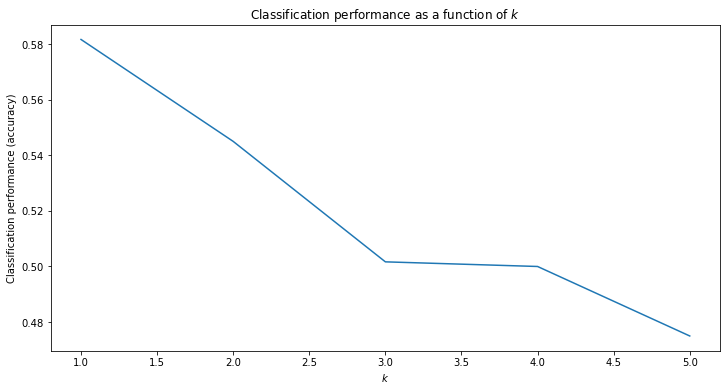

In [59]:
fig, ax = plt.subplots(1, figsize = (12,6))

ax.plot(ks, accs)
ax.set_title('Classification performance as a function of $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('Classification performance (accuracy)')
plt.show()

**C) For each $k$, examine the top 10 predictive words of each particle. Are your observations in line with the hypothesis made above?**

In [60]:
id2p

{0: 'over', 1: 'back', 2: 'around', 3: 'out'}

In [61]:
for k, top in zip(ks, tops):
    print(f"Context window of size {k}")
    
    for i in range(4):
        print(f"Top predictive words for {id2p[i]}")
        print(top[i], end = '\n\n')

Context window of size 1
Top predictive words for over
['parkinsons', 'profits', 'allies', 'essentially', 'convinced', 'new', 'isnt', 'won', 'almost', 'trade']

Top predictive words for back
['steps', '2050', 'drone', 'towards', 'yard', 'none', 'fight', 'own', 'might', 'conversation']

Top predictive words for around
['cruz', 'seconds', 'lines', 'bombers', 'actually', 'arent', 'spending', 'shop', 'wear', 'scandals']

Top predictive words for out
['made', 'mouth', 'missing', 'looks', 'threw', 'loaned', 'camp', 'hair', 'set', 'each']

Context window of size 2
Top predictive words for over
['possible', 'jail', 'conventions', 'source', 'serve', 'county', 'threat', '0', 'effectively', 'prospects']

Top predictive words for back
['invite', 'ohio', 'pushed', 'awhile', 'looking', 'bowl', 'overwhelming', 'centuries', 'insults', 'whenever']

Top predictive words for around
['slowly', 'sandy', 'finish', 'keeping', 'option', 'bow', 'flynn', 'student', 'attack', 'authoritarian']

Top predictive wor

### Part III: Feed-forward Neural Network Classifier

In [62]:
class FNNClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        
        super(FNNClassifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        hidden = torch.tanh(self.linear_1(x))
        output = self.linear_2(hidden)
        return output

In [63]:
k = 1

In [93]:
train

,sent_1,sent_2,label,enc_1,enc_2,sparse
1118,"[sandy, had]","[100b, in, funding, and, it, affected, way, mo...",around,"[0, 0, 0, 3031, 80]","[11, 4, 1051, 8, 5248]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
852,"[so, once, shes, there, theres, no, reason, to...","[even, if, you, buy, into, the, fallacy, that,...",around,"[62, 276, 3, 203, 11]","[91, 465, 13, 22, 72]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1431,"[as, a, result, they, gained, extraterritorial...","[the, world]",around,"[745, 371, 3920, 8, 2504]","[0, 0, 0, 131, 2]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4981,"[theyre, the, ones, paying, all, these, politi...","[so, they, can, price, gouge, necessities, for...",over,"[153, 516, 3, 263, 74]","[9339, 1625, 50, 14, 32]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3221,"[payment, for, class, a, drugs, , 1mhowever, w...",[],out,"[870, 39, 10, 2508, 27]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
5757,"[the, fact, that, a, contested, convention, is...","[on, the, first, ballot]",over,"[9, 39, 5, 1091, 158]","[0, 2607, 172, 2, 16]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2982,"[the, last, two, gop, presidential, nominees, ...","[to, the, center, in, time, for, the, national...",back,"[900, 3, 87, 7, 213]","[61, 8, 1514, 2, 3]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3808,"[im, not, old, by, any, terms, but, i, swear, ...","[curled, up, in, a, ball, unable, to, stop, co...",out,"[67, 3, 3783, 47, 67]","[2355, 5, 8, 47, 12852]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1447,"[a, few, of, the, women]","[my, campus, who, are, muslim, have, told, me,...",around,"[5, 169, 6, 2, 359]","[861, 21, 46, 12853, 53]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [64]:
for data in [train, dev, test]:
    data['sparse'] = data.apply(lambda x: sent2sparse(x.enc_1[-k:], x.enc_2[-k:], vocab), axis = 1)
    
# Transform data to tensors
train_x = torch.tensor(list(train['sparse'])).float()
train_y = torch.tensor([p2id[p] for p in train.label])

# Dev
dev_x = torch.tensor(list(dev['sparse'])).float()
dev_y = torch.tensor([p2id[p] for p in dev.label])

# Test
test_x = torch.tensor(list(test['sparse'])).float()
test_y = torch.tensor([p2id[p] for p in test.label])

In [65]:
input_dim = 5000
output_dim = 4

In [66]:
ds = [5,10,50,100,500]
accs = []

In [67]:
for d in ds:
    
    print(f"Using dimensions {d}")
    
    classifier = FNNClassifier(input_dim, output_dim, d)
    acc, true_ffn, pred_ffn = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
    
    # Store accuracies
    accs.append(acc)

Using dimensions 5
Accuracy on the dev data after 05 epochs: 0.3400
Accuracy on the dev data after 10 epochs: 0.4350
Accuracy on the dev data after 15 epochs: 0.5150
Accuracy on the dev data after 20 epochs: 0.5533
Accuracy on test data: 0.5333
Using dimensions 10
Accuracy on the dev data after 05 epochs: 0.4550
Accuracy on the dev data after 10 epochs: 0.5250
Accuracy on the dev data after 15 epochs: 0.5533
Accuracy on the dev data after 20 epochs: 0.5950
Accuracy on test data: 0.5700
Using dimensions 50
Accuracy on the dev data after 05 epochs: 0.5617
Accuracy on the dev data after 10 epochs: 0.5933
Accuracy on the dev data after 15 epochs: 0.6050
Accuracy on the dev data after 20 epochs: 0.6067
Accuracy on test data: 0.5983
Using dimensions 100
Accuracy on the dev data after 05 epochs: 0.5917
Accuracy on the dev data after 10 epochs: 0.5950
Accuracy on the dev data after 15 epochs: 0.6033
Accuracy on the dev data after 20 epochs: 0.6000
Accuracy on test data: 0.5983
Using dimensions

In [68]:
accs

[0.5333333611488342,
 0.5699999928474426,
 0.5983333587646484,
 0.5983333587646484,
 0.5799999833106995]

In [69]:
n = 5
for s1, s2, l, p_lr, p_ffn in zip(test.sent_1, test.sent_2, true_lr, pred_lr, pred_ffn):
    if l != p_lr and l == p_ffn:
        print(f"True: {id2p[l]}, Logistic: {id2p[p_lr]}, Neural Network: {id2p[p_ffn]}")
        print(' '.join(s1[-5:]), id2p[l], ' '.join(s2[:5]))
        
        n -= 1
        
    if n == 0:
        break

True: over, Logistic: out, Neural Network: over
more until things get converted over but it will happen
True: over, Logistic: back, Neural Network: over
the fbi cia and nsa over your delusionsoh and btw heres
True: around, Logistic: back, Neural Network: around
at bars restaurants parks strolling around it seems like the majority
True: out, Logistic: back, Neural Network: out
june 3rd and she dropped out on june 7thbut yeah sanderss
True: over, Logistic: around, Neural Network: over
some missile defense destroyers parked over by korea to handle it


**A) How
does this classifier compare to the logistic regression classifier?**

**B) Plot the accuracy as a function of the hidden dimension $d$. What do you observe?**

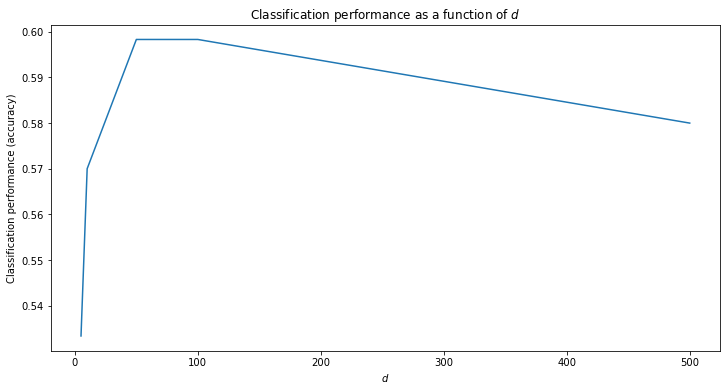

In [70]:
# Create plot of classification performance as a function of k
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(ds, accs)
ax.set_title('Classification performance as a function of $d$')
ax.set_xlabel('$d$')
ax.set_ylabel('Classification performance (accuracy)')

plt.show()

### Part IV: LSTM Classifier

In [71]:
class LSTMClassifier(nn.Module):
    
    # Pass hyperparameters as arguments
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout, context):
        
        super(LSTMClassifier, self).__init__()
        
        self.context = context
        
        if self.context in {'left', 'both'}:
            
            # Define embedding and LSTM layers for the left context
            self.embedding_1 = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
            self.lstm_1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
            
        if self.context in {'right', 'both'}:
            self.embedding_2 = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
            self.lstm_2 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
            
        if self.context in {'left', 'right'}:
            
            # Define a dense layer 
            self.linear = nn.Linear(hidden_dim, output_dim)
            
        if self.context == 'both':
            self.linear = nn.Linear(2 * hidden_dim, output_dim)
            
        # Define dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        sent_1, sent_2 = torch.chunk(x, 2, dim = -1) # <-- what is this?
        
        if self.context in {'left', 'both'}:
            emb_1 = self.dropout(self.embedding_1(sent_1))
            output_1, (hidden_1, cell_1) = self.lstm_1(emb_1)
            
        if self.context in {'right', 'both'}:
            emb_2 = self.dropout(self.embedding_2(sent_2))
            output_2, (hidden_2, cell_2) = self.lstm_2(emb_2)
            
        if self.context == 'left':
            output = self.linear(self.dropout(output_1[:, -1, :]))
            
        if self.context == 'right':
            
            output = self.linear(self.dropout(output_2[:, -1, :]))
            
        if self.context == 'both':
            
            # Concat and pass together
            concat = torch.cat((output_1[:, -1, :], output_2[:, -1, :]), dim=-1)
            output = self.linear(self.dropout(concat))
            
        return output

In [72]:
# Train 1
torch1 = torch.tensor(list(train.enc_1))
torch2 = torch.tensor(list(train.enc_2))
train_x = torch.cat((torch1, torch2), dim = -1)
train_y = torch.tensor([p2id[p] for p in train.label])

# Dev
torch1 = torch.tensor(list(dev.enc_1))
torch2 = torch.tensor(list(dev.enc_2))
dev_x = torch.cat((torch1, torch2), dim = -1)
dev_y = torch.tensor([p2id[p] for p in dev.label])

# Test
torch1 = torch.tensor(list(test.enc_1))
torch2 = torch.tensor(list(test.enc_2))
test_x = torch.cat((torch1, torch2), dim = -1)
test_y = torch.tensor([p2id[p] for p in test.label])

In [82]:
train_x

tensor([[    0,     0,     0,  ...,  1051,     8,  5248],
        [   62,   276,     3,  ...,    13,    22,    72],
        [  745,   371,  3920,  ...,     0,   131,     2],
        ...,
        [   67,     3,  3783,  ...,     8,    47, 12852],
        [    5,   169,     6,  ...,    46, 12853,    53],
        [   12,   152,    46,  ...,     0,     0, 12854]])

In [73]:
# Define hyperparameters
input_dim = len(w2id) + 2

In [74]:
input_dim

12855

In [124]:
w2id

{'the': 2,
 'to': 3,
 'and': 4,
 'a': 5,
 'of': 6,
 'that': 7,
 'in': 8,
 'is': 9,
 'i': 10,
 'it': 11,
 'for': 12,
 'you': 13,
 'they': 14,
 'be': 15,
 'on': 16,
 'but': 17,
 'was': 18,
 'have': 19,
 'as': 20,
 'are': 21,
 'if': 22,
 'with': 23,
 'people': 24,
 'he': 25,
 'not': 26,
 'this': 27,
 'all': 28,
 'or': 29,
 'its': 30,
 'just': 31,
 'so': 32,
 'we': 33,
 'like': 34,
 'their': 35,
 'at': 36,
 'would': 37,
 'get': 38,
 'when': 39,
 'trump': 40,
 'about': 41,
 'will': 42,
 'because': 43,
 'them': 44,
 'more': 45,
 'who': 46,
 'up': 47,
 'from': 48,
 'his': 49,
 'can': 50,
 'by': 51,
 'has': 52,
 'my': 53,
 'an': 54,
 'what': 55,
 'there': 56,
 'do': 57,
 'were': 58,
 'dont': 59,
 'one': 60,
 'time': 61,
 'no': 62,
 'then': 63,
 'your': 64,
 'she': 65,
 'been': 66,
 'going': 67,
 'her': 68,
 'some': 69,
 '': 70,
 'than': 71,
 'even': 72,
 'him': 73,
 'us': 74,
 'how': 75,
 'go': 76,
 'think': 77,
 'only': 78,
 'im': 79,
 'had': 80,
 'me': 81,
 'which': 82,
 'years': 83,
 'way':

In [75]:
embedding_dim = 300
hidden_dim = 200
output_dim = 4
dropout = 0.5

In [76]:
classifier = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, dropout, 'both')

In [77]:
acc, true_b, pred_b = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

Accuracy on the dev data after 05 epochs: 0.5900
Accuracy on the dev data after 10 epochs: 0.6417
Accuracy on the dev data after 15 epochs: 0.6683
Accuracy on the dev data after 20 epochs: 0.6817
Accuracy on test data: 0.6833


In [88]:
train_x[0]

tensor([   0,    0,    0, 3031,   80,   11,    4, 1051,    8, 5248])

In [78]:
# Inspect cases of wrong feed-forward neural network predictions and correct LSTM predictions
n = 5

for s_1, s_2, l, p_ffn, p_lstm in zip(test.sent_1, test.sent_2, true_ffn, pred_ffn, pred_b):
    if l != p_ffn and l == p_lstm:
        print(id2p[l], id2p[p_ffn], id2p[p_lstm])
        print('\t'.join(s_1[-5:]), '\t\t', '\t'.join(s_2[:5]))
        print()
        n -= 1

    if n == 0:
        break  

over around over
preserve	them	indefinitely	and	hopefully 		 time	with	sound	management	increase

around over around
hell	california	is	knocking 		 the	idea	of	a	statewide

around over around
can	happen	is	everyone	walks 		 looking	awesome

over around over
capitalism	to	be	moderately	healthy 		 time	would	require	it	to

over around over
wanting	to	favor	domestic	dairies 		 importing	from	the	us



**A) How
does the LSTM classifier compare to the feed-forward neural network classifier?**

**B)  Modify the LSTM architecture so that it only takes the left or right context into account. Train and test these two models. Which of the two contexts provides more information for
particle prediction?**

**C) Tabulate the number of misclassified examples as a function of the number of UNK tokens
in the left and right contexts. Manually inspect a couple of misclassified examples. What do
you observe? How do your observations relate to results of earlier parts of the formative?**

**D) Create a confusion matrix of the predicted labels versus the true labels. What do you
observe?**

### Part V: Overall Discussion

**Compare the three models to the trigram model presented in class. What information is available for the classifier in each of the four approaches? Are you able to interpret the overall
success of the models in relation to the information that is available in each one and the ability
to exploit it in an optimal fashion?**